In [1]:
import sys
sys.path.insert(0, "../input/im-net-py")

from im_net import Network, TripletDataset, ToTensor, ImNetLoss, Utils

import numpy as np
import os

import torch
import torch.nn.functional as F
from torchvision.transforms.functional import vflip, hflip
from torch.utils.data import Dataset, DataLoader
import torchvision 
import cv2
import random

from matplotlib import pyplot as plt
from IPython.display import Image as Show
from PIL import Image

PATH_TEST = '../input/vimeo-small/to kaggle/To kaggle'
PATH_TRAIN = '../input/vimeo-small/00011'

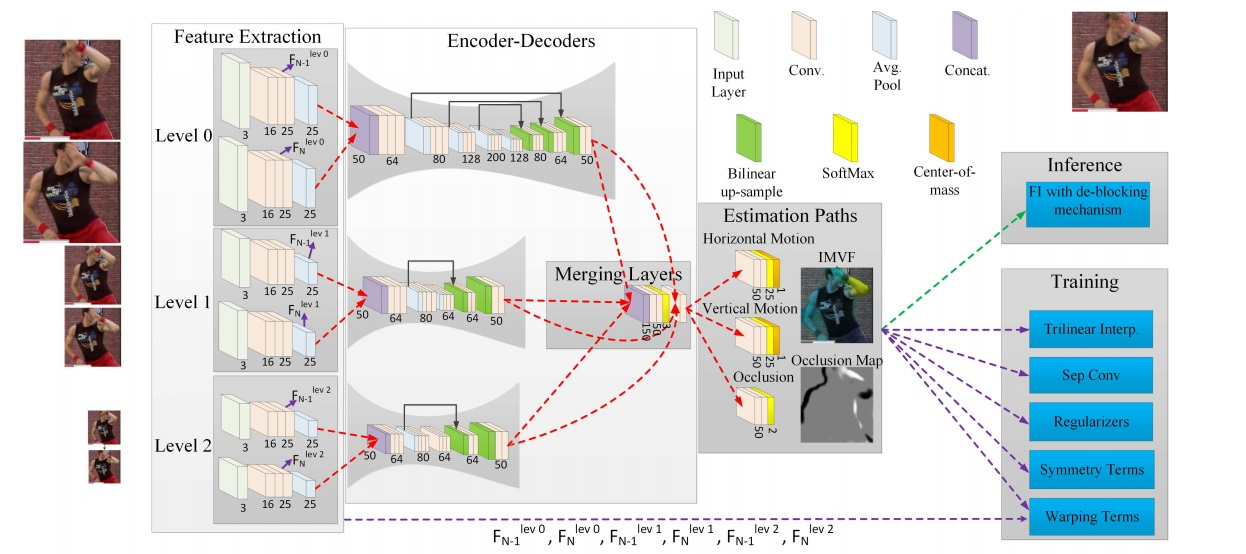

In [2]:
# NN Architecture
Show("../input/imagesource/NN.jpg", width=1200)

_____________________________________________

- Строится 3-и пары изображений размерами : WxH, W/2xH/2, W/4xH/4
- Каждая пара подается на вход первому блоку (Feature Extraction) архитектуры IM-Net, все пары проходят через одинаковые слои (Siamese)
- Дальше каждая пара подается на вход второму блоку (Encoder-Decoders).
Тут каждая пара объединяется, проходит через различные ветки архитектуры, получаются 3-и представления размером (W/8, H/8, 50).
Далее эти представления объединяются в одно, путем попиксельного сложения разных представлений с весами получаемыми из SoftMax блока (см. MERGING BRANCHES LAYERS из im_net.Network)
- В конце, объединённое представление передается в три параллельные Estimation Paths, где Horizonta Motion и Vertical Motion извлекают карту сдвига пикселей, а Occlusion карту окклюзии соответственно.
Главная идея - лучше всего работает именно классификация сдвига в каждом пикселе, а не регрессионная модель (классификация преобразуется в числовое значение сдвига через расчет центра масс, размах возможного сдвига в моей реализации [-12, 12] пикселей, что для исходного размера изображения равно [-96, 96])

_____________________________________________

In [3]:
model = Network() 
optimizer = torch.optim.Adam(model.parameters(), lr=10e-4)
device = torch.device('cuda')
model = model.to(device)

In [4]:
batch_size = 16
transform = torchvision.transforms.Compose([ToTensor()])
dataset_train = TripletDataset(PATH_TRAIN, transform=transform) # VIMEO DATASET (http://data.csail.mit.edu/tofu/dataset/vimeo_triplet.zip)
dataloader_train = DataLoader(dataset_train, batch_size=batch_size,
                        shuffle=True, num_workers=4)
dataset_test = TripletDataset(PATH_TEST, transform=transform)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size,
                        shuffle=True, num_workers=4)
Loss=ImNetLoss(device)

In [5]:
train_loss = list()
test_loss = list()
EPOCH = 20
for epoch in range(EPOCH):
    per_epoch_loss_train = 0
    per_epoch_loss_test = 0
    
    for i,sample_batched in enumerate(dataloader_train):
        optimizer.zero_grad()
        F_mid_pred, F_mid_hi_pred, toLoss = model(*Utils.batch_to_model(sample_batched, device))
        loss = Loss.loss_calculation(F_mid_pred, F_mid_hi_pred, toLoss, sample_batched) 
        per_epoch_loss_train += loss.item()
        loss.backward()
        optimizer.step()        
    train_loss.append(-20 * np.log10(per_epoch_loss_train / len(dataloader_train)))
    print(f'train loss - {train_loss[-1]}')
    
    for i,sample_batched in enumerate(dataloader_test):
        F_mid_pred, F_mid_hi_pred, toLoss = model(*Utils.batch_to_model(sample_batched, device))
        loss = Loss.loss_calculation(F_mid_pred, F_mid_hi_pred, toLoss, sample_batched)
        per_epoch_loss_test += loss.item()
    test_loss.append(-20 * np.log10(per_epoch_loss_test / len(dataloader_test)))
    print(f'test loss - {test_loss[-1]}')

train loss - 30.9040670498816
test loss - 30.18889476132495
train loss - 31.839784937123227
test loss - 30.3809796204745
train loss - 32.56868566450191
test loss - 32.73026265830873
train loss - 34.9550831835515
test loss - 33.86818024133219
train loss - 35.7317609282202
test loss - 34.37623878431562
train loss - 36.24457525223042
test loss - 34.844029416991106
train loss - 36.6167056328191
test loss - 35.17054597820872
train loss - 36.90188713883888
test loss - 35.360583584436604
train loss - 37.07048660252063
test loss - 35.620568630644996
train loss - 37.338559247619315
test loss - 35.78501716493325
train loss - 37.48902450516462
test loss - 35.65188326264511
train loss - 37.61616200290629
test loss - 35.83519590240072
train loss - 37.805593404205766
test loss - 36.14945387562922
train loss - 37.988183977650415
test loss - 36.17459632725966
train loss - 38.046516545550475
test loss - 36.331197836630636
train loss - 38.18477033712234
test loss - 36.49931509444927
train loss - 38.3418

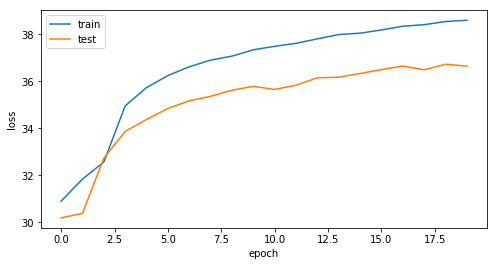

In [6]:
plt.figure(figsize=(8,4))
plt.plot(train_loss)
plt.plot(test_loss)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

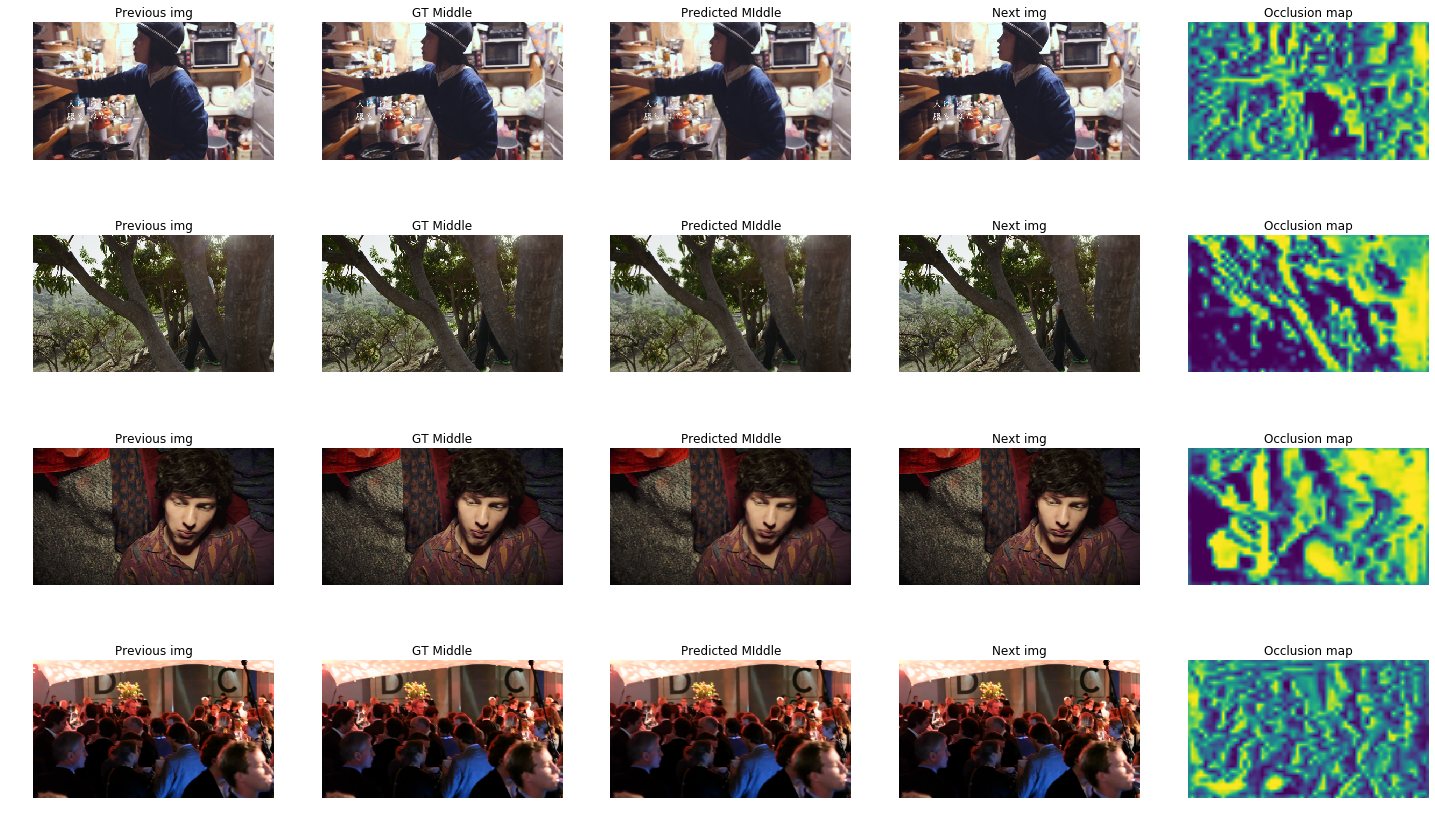

In [7]:
fig, ax = plt.subplots(4,5,figsize=(25,15))
for i in range(4):
    ax[i,0].imshow(sample_batched['img_hi_res'][0][i].numpy().transpose(1,2,0))
    ax[i,0].set_title('Previous img')
    ax[i,0].axis('off')
    ax[i,1].imshow(sample_batched['mid_img'][0][i].numpy().transpose(1,2,0))
    ax[i,1].set_title('GT Middle')
    ax[i,1].axis('off')
    ax[i,2].imshow(F_mid_hi_pred[i].cpu().detach().numpy().transpose(1,2,0))
    ax[i,2].set_title('Predicted MIddle')
    ax[i,2].axis('off')
    ax[i,3].imshow(sample_batched['img_hi_res'][1][i].numpy().transpose(1,2,0))
    ax[i,3].set_title('Next img')
    ax[i,3].axis('off')
    ax[i,4].imshow(toLoss[6][i][0].cpu().detach().numpy())
    ax[i,4].set_title('Occlusion map')
    ax[i,4].axis('off')

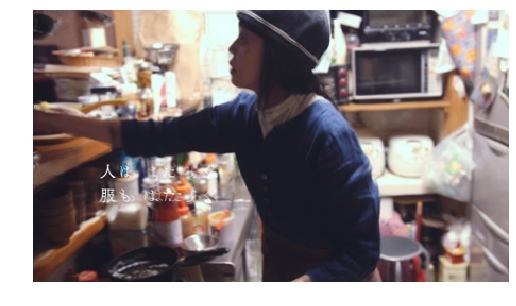

In [8]:
plt.figure(figsize=(10,5))
plt.imshow(F_mid_hi_pred[0].cpu().detach().numpy().transpose(1,2,0))
plt.axis('off')
plt.show()